Brief recommendations from on-demand mentor:
- Vector regression:
    - sarimax, (time series/arima)
    - vector autoregressor,
    - from statsmodels https://www.statsmodels.org/dev/vector_ar.html
- or Facebook "kats"
- prophet or neural_prophet
- LinkedIn Greykite
- Uber Orbit
- Kaggle time series contest (forecasting)
- gradient or xgboost, lightgbm 
    - didn't seem to work as classification!
    
See statsmodels for trending and seasonality (do this for one stock first)
- https://www.statsmodels.org/dev/examples/notebooks/generated/stationarity_detrending_adf_kpss.html
- then https://www.statsmodels.org/dev/examples/notebooks/generated/stl_decomposition.html

Reread arima notes, I'm getting lost on the math
- https://robjhyndman.com/hyndsight/arimax/
- https://www.statsmodels.org/dev/statespace.html

Also look more at series filters
- https://www.statsmodels.org/dev/examples/notebooks/generated/tsa_filters.html

Other thoughts:
- Do another for messing around with decision trees? Will stock go up/down lot/little?
- Run PCA on the data (or what's the version of PCA that keeps the component identities?)
- just drop the sparse columns, too complicated
- where would I get inflation info to detrend? Or can I let a model figure that out?
- Also referring back to CowboyCigs case study, and remind myself how to do autocorrelation plots

In [42]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [2]:
df = pd.read_csv('hf-3-day-prices.csv', parse_dates=['date'])

In [3]:
# redoing some work in order to find all the sparse columns
# narrow down to tech stocks with most complete revenues data
tech_revenues = ['CSCO', 'FB', 'GOOGL', 'HPQ', 'IBM', 'ORCL']
df_tr = df[df['ticker'].isin(tech_revenues)]

In [4]:
# drop lots of extraneous price data
dropcols = ['split_coefficient', 'split_coef_minus1', 'split_coef_plus1', 'open', 'high', 'low', 'close_adjusted', 
            'volume', 'date_minus1', 'open_minus1', 'high_minus1', 'low_minus1', 'close_adj_minus1', 'volume_minus1', 
            'date_plus1', 'open_plus1', 'high_plus1', 'low_plus1', 'close_adj_plus1', 'volume_plus1']
df_tr = df_tr.drop(dropcols, axis=1)

# drop SEC data with less than 70% reporting
# credit: https://stackoverflow.com/questions/43311555/how-to-drop-column-according-to-nan-percentage-for-dataframe
nan_percent = 0.7
threshold = int(len(df_tr.index) * nan_percent)
df_tr = df_tr.dropna(thresh=threshold, axis=1)
df_tr.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 199 entries, 713 to 1983
Data columns (total 16 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   ticker                            199 non-null    object        
 1   date                              199 non-null    datetime64[ns]
 2   commonstocksharesissued           160 non-null    float64       
 3   assetscurrent                     199 non-null    float64       
 4   accountspayablecurrent            199 non-null    float64       
 5   liabilitiesandstockholdersequity  199 non-null    float64       
 6   stockholdersequity                199 non-null    float64       
 7   earningspersharebasic             199 non-null    float64       
 8   netincomeloss                     199 non-null    float64       
 9   depreciation                      139 non-null    float64       
 10  revenues                          195 non-null 

In [5]:
# where am I missing close prices?
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(df_tr[df_tr['close'].isnull()])

,ticker,date,commonstocksharesissued,assetscurrent,accountspayablecurrent,liabilitiesandstockholdersequity,stockholdersequity,earningspersharebasic,netincomeloss,depreciation,revenues,costofservices,debtcurrent,close,close_minus1,close_plus1
1375,IBM,2012-10-30,2.182470e+09,4.814100e+10,7.085000e+09,1.157780e+11,2.154100e+10,9.38,15000000.0,2.572000e+09,563000000.0,2.928500e+10,9.334000e+09,NaN,NaN,194.53


In [6]:
# for one row, I will just make the close price equal to the "plus1" data point because it's what I have.
# also need to fill in missing plus1 and minus1 prices (set to day-of price)
df_tr['close'].fillna(value=df_tr['close_plus1'], axis=0, inplace=True)
df_tr['close_minus1'].fillna(value=df_tr['close'], axis=0, inplace=True)
df_tr['close_plus1'].fillna(value=df_tr['close'], axis=0, inplace=True)
df_tr.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 199 entries, 713 to 1983
Data columns (total 16 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   ticker                            199 non-null    object        
 1   date                              199 non-null    datetime64[ns]
 2   commonstocksharesissued           160 non-null    float64       
 3   assetscurrent                     199 non-null    float64       
 4   accountspayablecurrent            199 non-null    float64       
 5   liabilitiesandstockholdersequity  199 non-null    float64       
 6   stockholdersequity                199 non-null    float64       
 7   earningspersharebasic             199 non-null    float64       
 8   netincomeloss                     199 non-null    float64       
 9   depreciation                      139 non-null    float64       
 10  revenues                          195 non-null 

In [28]:
# interpolate in ticker groups. In-place doesn't seem to work. Remember to "apply" instead of "transform" so the ticker column
# does not vanish!
df_interp = df_tr.groupby('ticker').apply(pd.DataFrame.interpolate)
df_interp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 199 entries, 713 to 1983
Data columns (total 16 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   ticker                            199 non-null    object        
 1   date                              199 non-null    datetime64[ns]
 2   commonstocksharesissued           160 non-null    float64       
 3   assetscurrent                     199 non-null    float64       
 4   accountspayablecurrent            199 non-null    float64       
 5   liabilitiesandstockholdersequity  199 non-null    float64       
 6   stockholdersequity                199 non-null    float64       
 7   earningspersharebasic             199 non-null    float64       
 8   netincomeloss                     199 non-null    float64       
 9   depreciation                      145 non-null    float64       
 10  revenues                          199 non-null 

In [30]:
# remember that I'm actually looking for how the price changed!
# Create two target dataframes: one for minus1 to day-of, one for day-of to plus1
df_minus_dayof = df_interp.copy(deep=True)
df_dayof_plus = df_interp.copy(deep=True)
df_minus_dayof['change'] = df_minus_dayof['close'] - df_minus_dayof['close_minus1']
df_dayof_plus['change'] = df_dayof_plus['close_plus1'] - df_dayof_plus['close']
# drop the actual price columns
dropprice = ['close', 'close_minus1', 'close_plus1']
df_minus_dayof.drop(dropprice, axis=1, inplace=True)
df_dayof_plus.drop(dropprice, axis=1, inplace=True)
# make sure my changes are usually different!
display(df_minus_dayof.iloc[0:5,-1:])
display(df_dayof_plus.iloc[0:5,-1:])

,change
713,-0.0900
714,0.0700
715,-0.4200
716,-0.1099
717,-0.3600


,change
713,-0.32
714,0.21
715,0.78
716,0.03
717,0.26


In [31]:
# now for the tricky part. What I really have here is six different time series, one for each ticker...
# 'CSCO', 'FB', 'GOOGL', 'HPQ', 'IBM', 'ORCL'.
# I played around a bit and IBM has most complete data, so I'm going to try all this on IBM and day-plus DF.

df_IBM = df_dayof_plus[df_dayof_plus['ticker'] == 'IBM'].drop(columns='ticker')
df_IBM.set_index('date', drop=True, inplace=True)
df_IBM.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 40 entries, 2009-07-28 to 2019-04-30
Data columns (total 12 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   commonstocksharesissued           40 non-null     float64
 1   assetscurrent                     40 non-null     float64
 2   accountspayablecurrent            40 non-null     float64
 3   liabilitiesandstockholdersequity  40 non-null     float64
 4   stockholdersequity                40 non-null     float64
 5   earningspersharebasic             40 non-null     float64
 6   netincomeloss                     40 non-null     float64
 7   depreciation                      40 non-null     float64
 8   revenues                          40 non-null     float64
 9   costofservices                    40 non-null     float64
 10  debtcurrent                       40 non-null     float64
 11  change                            40 non-null     flo

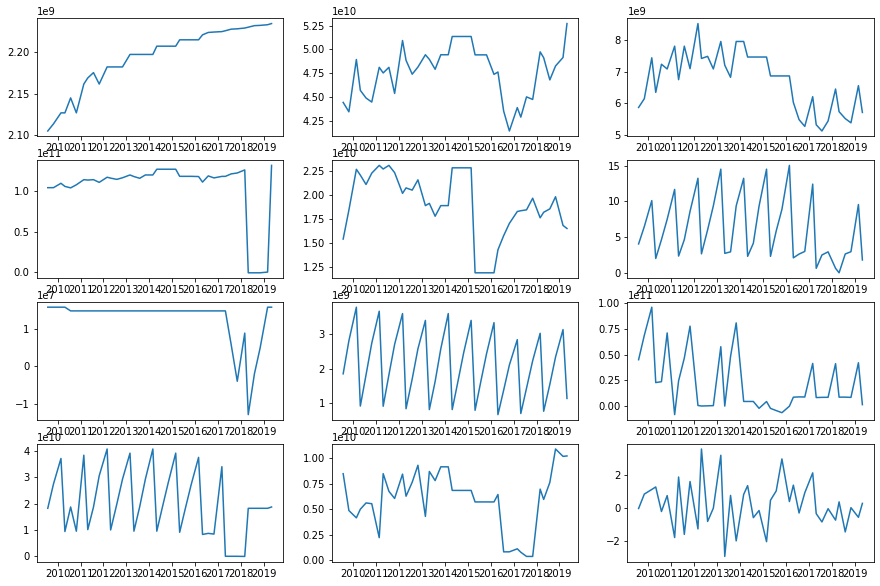

In [41]:
# series exploration!
# axes credit: https://stackoverflow.com/questions/46862861/what-does-axes-flat-in-matplotlib-do
n_cols = 3
n_rows = int(round(df_IBM.shape[1]/n_cols, 0))
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(15,10))

for i, ax in enumerate(axes.flat):
    if i in range(df_IBM.shape[1]):
        ax.plot(df_IBM.iloc[:,i])
        ax.xlabel = df_IBM.columns[i]
plt.show()

I see some series with trend, some with seasonality, and some that just look all over the place. Also massive differences in scale, although I knew that already.

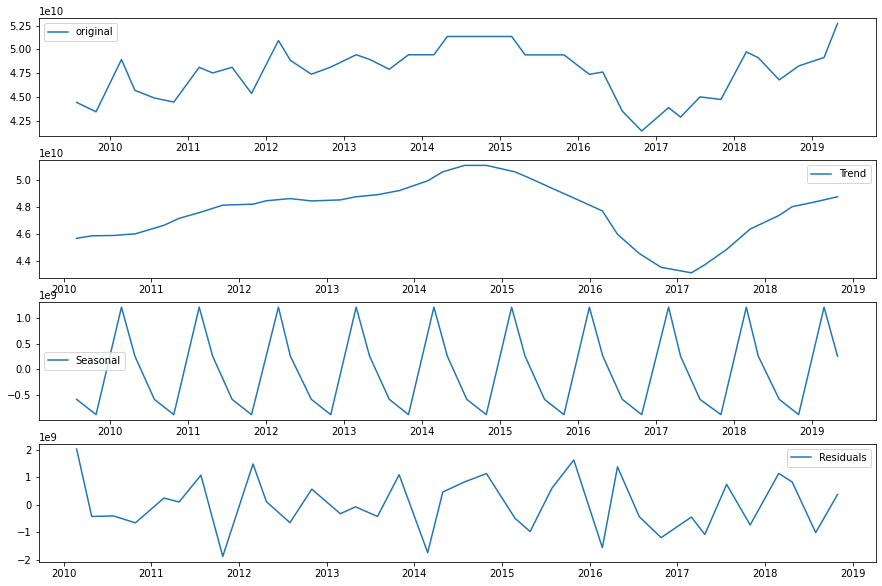

In [45]:
# try decomposing some of these columns
from statsmodels.tsa.seasonal import seasonal_decompose

decomposed = seasonal_decompose(df_IBM['assetscurrent'], period=4) # I'm guessing 4 because SEC filings are quarterly

trend = decomposed.trend
seasonal = decomposed.seasonal
residual = decomposed.resid

# Plot the original data, the trend, the seasonality, and the residuals 
plt.figure(figsize=(15,10))
plt.subplot(411)
plt.plot(df_IBM['assetscurrent'], label = 'original')
plt.legend(loc = 'best')
plt.subplot(412)
plt.plot(trend, label = 'Trend')
plt.legend(loc = 'best')
plt.subplot(413)
plt.plot(seasonal, label = 'Seasonal')
plt.legend(loc = 'best')
plt.subplot(414)
plt.plot(residual, label = 'Residuals')
plt.legend(loc = 'best')
plt.show()

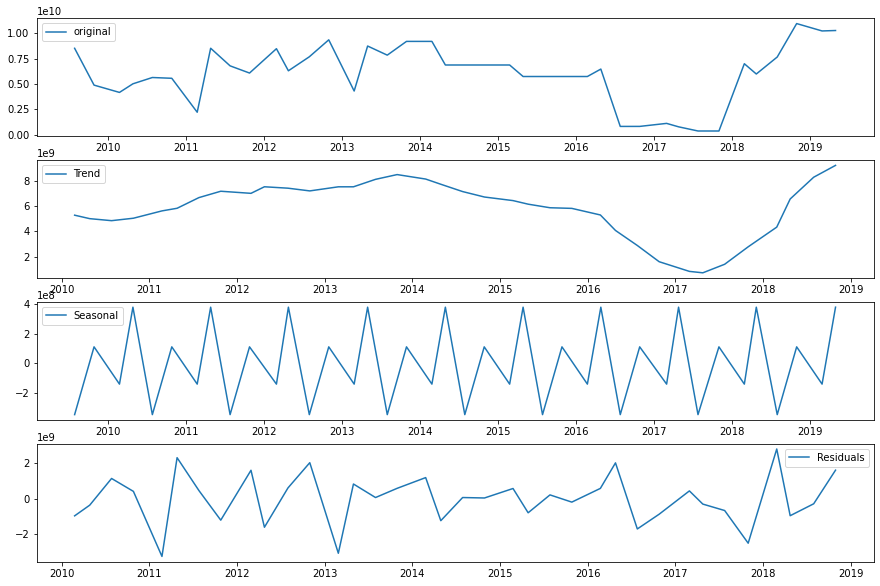

In [46]:
y = df_IBM['debtcurrent'] # yes, I'm picking the weirder looking graphs first!
decomposed = seasonal_decompose(y, period=4) # I'm guessing 4 because SEC filings are quarterly

trend = decomposed.trend
seasonal = decomposed.seasonal
residual = decomposed.resid

# Plot the original data, the trend, the seasonality, and the residuals 
plt.figure(figsize=(15,10))
plt.subplot(411)
plt.plot(y, label = 'original')
plt.legend(loc = 'best')
plt.subplot(412)
plt.plot(trend, label = 'Trend')
plt.legend(loc = 'best')
plt.subplot(413)
plt.plot(seasonal, label = 'Seasonal')
plt.legend(loc = 'best')
plt.subplot(414)
plt.plot(residual, label = 'Residuals')
plt.legend(loc = 'best')
plt.show()

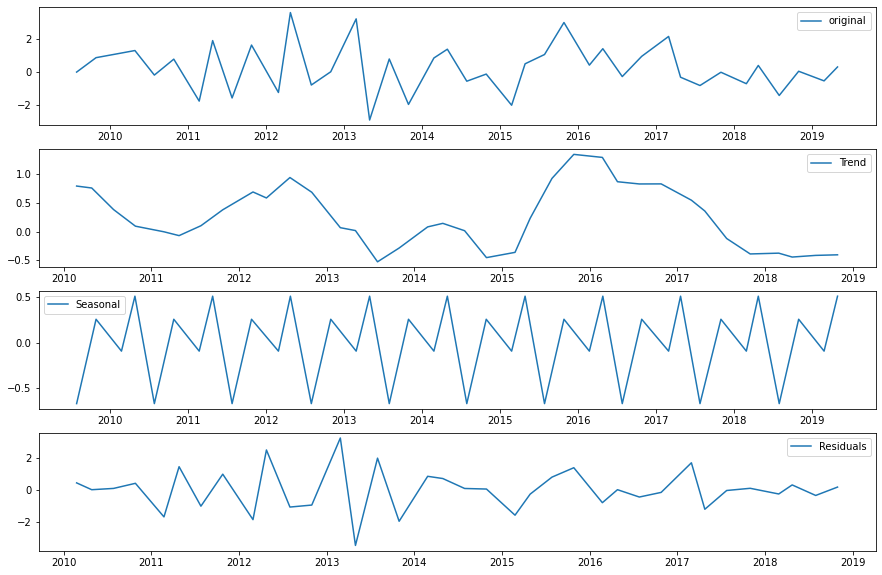

In [47]:
y = df_IBM['change'] # yes, I'm picking the weirder looking graphs first!
decomposed = seasonal_decompose(y, period=4) # I'm guessing 4 because SEC filings are quarterly

trend = decomposed.trend
seasonal = decomposed.seasonal
residual = decomposed.resid

# Plot the original data, the trend, the seasonality, and the residuals 
plt.figure(figsize=(15,10))
plt.subplot(411)
plt.plot(y, label = 'original')
plt.legend(loc = 'best')
plt.subplot(412)
plt.plot(trend, label = 'Trend')
plt.legend(loc = 'best')
plt.subplot(413)
plt.plot(seasonal, label = 'Seasonal')
plt.legend(loc = 'best')
plt.subplot(414)
plt.plot(residual, label = 'Residuals')
plt.legend(loc = 'best')
plt.show()

So... what can I do with decomposition? Is it useful to engineer out trend or seasonality? Would that make the data more amenable to classification or regression analysis? Can I compare or predict things by their trend or seasonal changes?

In [49]:
# testing for stationarity (I'm guessing not much!)
from statsmodels.tsa.stattools import kpss
kpss(y, nlags='auto')

D:\Documents\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1876: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(warn_msg.format(direction="greater"), InterpolationWarning)


(0.09637257782251911,
 0.1,
 2,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

In [50]:
# okay, it thinks the price-change series is stationary...
y = df_IBM['debtcurrent']
kpss(y, nlags='auto')

D:\Documents\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1876: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(warn_msg.format(direction="greater"), InterpolationWarning)


(0.12080228451781883,
 0.1,
 3,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

In [52]:
y = df_IBM['commonstocksharesissued'] # this one better not be stationary!
kpss(y, nlags='auto')

D:\Documents\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1874: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(warn_msg.format(direction="smaller"), InterpolationWarning)


(0.8437492697765796,
 0.01,
 4,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

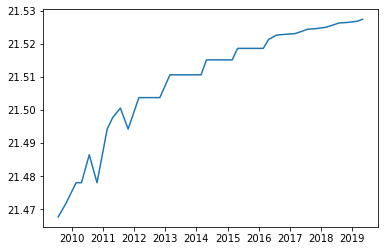

In [53]:
y_log = np.log(y)
plt.plot(y_log)

In [54]:
kpss(y_log.diff().dropna()) # so log and diff just result in stationarity for this series.

(0.4124797886882645,
 0.07177595315161013,
 10,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

In [55]:
# following https://www.statsmodels.org/dev/vector_ar.html for the moment.
# Does one just log and diff all the data customarily as part of doing ARIMA?
from statsmodels.tsa.api import VAR
data = np.log(df_IBM).diff().dropna()
model = VAR(data)
results = model.fit(4) # again, I'm guessing 4 lags because quarterly reporting...
results.summary()

<ipython-input-55-2711d45d6dd8>:4: RuntimeWarning: divide by zero encountered in log
  data = np.log(df_IBM).diff().dropna()
<ipython-input-55-2711d45d6dd8>:4: RuntimeWarning: invalid value encountered in log
  data = np.log(df_IBM).diff().dropna()
D:\Documents\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency WOM-4TUE will be used.
  warnings.warn('No frequency information was'


LinAlgError: SVD did not converge in Linear Least Squares

Okay, so there's at least one value in there I can't log. Probably negative price change values. No idea what the "SVD did not converge" error means.

In [56]:
data = df_IBM.diff().dropna()
model = VAR(data)
results = model.fit(4) # again, I'm guessing 4 lags because quarterly reporting...
results.summary()

D:\Documents\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\Documents\Anaconda3\lib\site-packages\statsmodels\tsa\vector_ar\var_model.py:1450: RuntimeWarning: invalid value encountered in sqrt
  stderr = np.sqrt(np.diag(self.cov_params()))


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 10, Sep, 2021
Time:                     19:51:55
--------------------------------------------------------------------
No. of Equations:         12.0000    BIC:                   -204.009
Nobs:                     35.0000    HQIC:                  -221.118
Log likelihood:           4019.47    FPE:               6.27582e-106
AIC:                     -230.138    Det(Omega_mle):    1.71844e-110
--------------------------------------------------------------------
Results for equation commonstocksharesissued
                                         coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------------------------------
const                                       0.000000        25.606643            0.000           1.000
L1.commonstocksharesissued                  0.179008     

Yup, I'm in over my head again. Don't know really what the numbers mean, but when std.error is generally 0, NAN, or HUGE, I get suspicious. Also the probability 1/0/NAN bothers me.

In [59]:
# F---ing around with some of the other features of VAR model while I'm here...
norm = results.test_normality()
norm.summary()

Test statistic,Critical value,p-value,df
104.9,36.42,0.000,24


In [60]:
white = results.test_whiteness()
white.summary()

Test statistic,Critical value,p-value,df
1327.,933.5,0.000,864


Is this saying I have "residual autocorrelation"? I mean, that makes some sense, in theory the assorted SEC data should be essentially reflecting the same changes in the business, right?

I spent quite a bit of time banging my head on "my data isn't normal" already. Still not sure what the right answer is.

no diff:  (-8.973147778476656, 7.656968203134588e-15, 0, 39, {'1%': -3.610399601308181, '5%': -2.939108945868946, '10%': -2.6080629651545038}, 106.45769262284915)
1 diff:  (-5.694475399220567, 7.932205457908062e-07, 3, 35, {'1%': -3.6327426647230316, '5%': -2.9485102040816327, '10%': -2.6130173469387756}, 102.83922318878611)
2 diff:  (-5.517962797396069, 1.9060085778667713e-06, 5, 32, {'1%': -3.653519805908203, '5%': -2.9572185644531253, '10%': -2.6175881640625}, 105.54248089094186)


NameError: name 'plot' is not defined

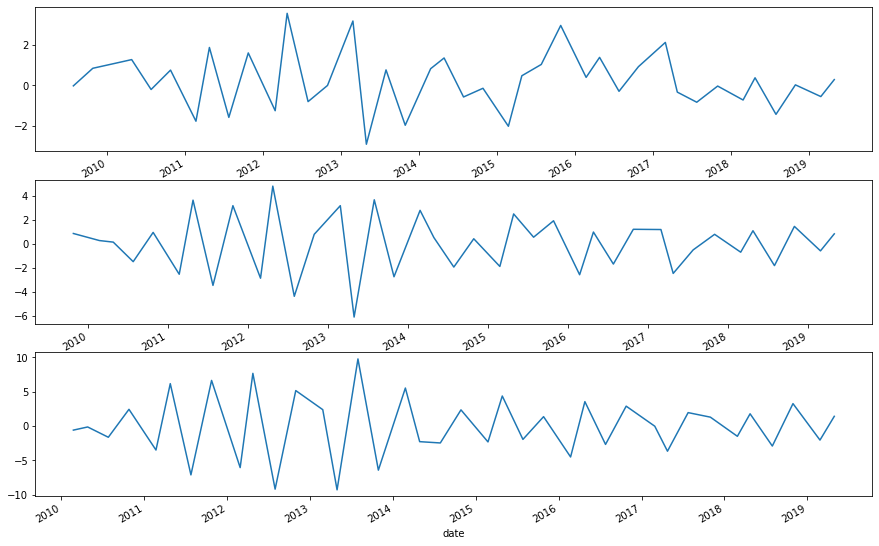

In [71]:
# find autocorrelation plot...
# armax? Treat "change" as target and each other column as an exog?
# choosing difference order: brute force, adfuller on series, adfuller on series.diff(), possibly diff.diff... until p-value is
#    low enough to indicate stationarity
# why tf did nobody tell me there's such a thing as an "explanatory model"? That's totally what I've been asking for.

# okay, building on the next TS DataCamp course, let's try to figure out one column time series prediction. 
y = df_IBM['change']
# Do the ADF stationarity testing
from statsmodels.tsa.stattools import adfuller
adf = adfuller(y)
print("no diff: ", adf)
adf1 = adfuller(y.diff().dropna())
print("1 diff: ", adf1)
adf2 = adfuller(y.diff().diff().dropna())
print("2 diff: ", adf2)

fig, (ax1, ax2, ax3) = plt.subplots(3,1, figsize=(15,10))
y.plot(ax=ax1)
y.diff().plot(ax=ax2)
y.diff().diff().plot(ax=ax3)
plot.show()

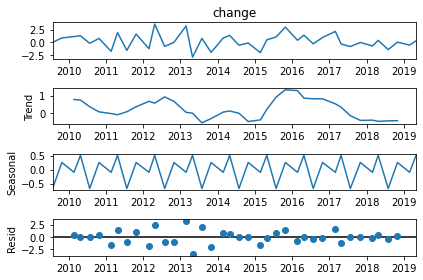

In [64]:
# even 2 diff doesn't produce stationarity?
# Do a seasonal decompose
decomposed = seasonal_decompose(y, period=4) # I'm guessing 4 because SEC filings are quarterly
decomposed.plot()
plt.show()


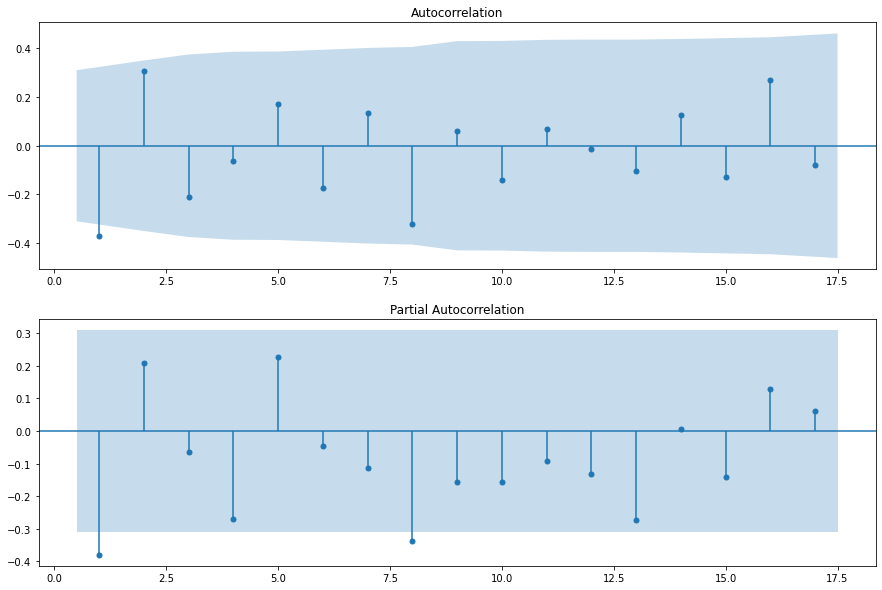

In [68]:
# Do ACF/PACF plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, (ax1, ax2) = plt.subplots(2,1, figsize=(15,10))
plot_acf(y, zero=False, ax=ax1)
plot_pacf(y, zero=False, ax=ax2)
plt.show()


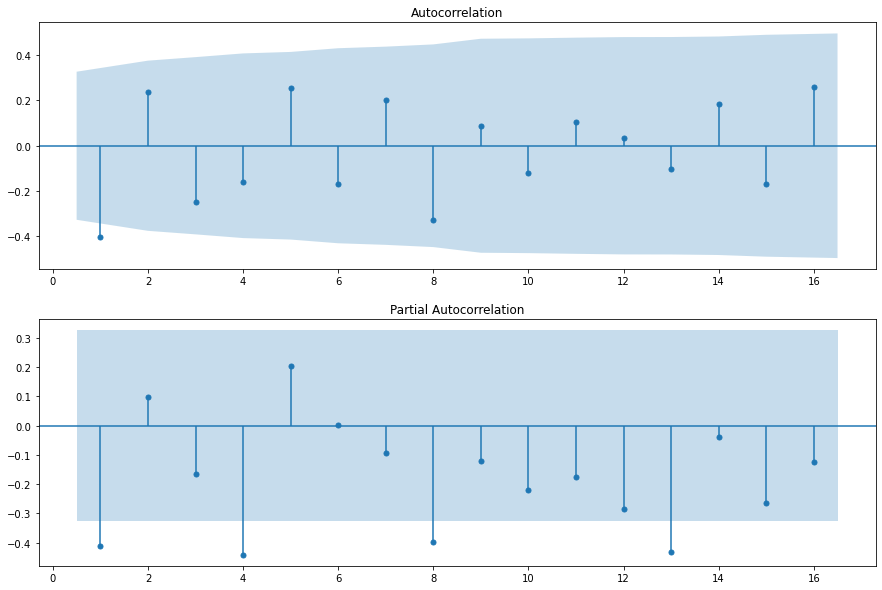

In [70]:
# check for seasonal differences:
# detrend and plot a "seasonal" ACF/PACF
y_roll = y - y.rolling(5).mean()

fig, (ax1, ax2) = plt.subplots(2,1, figsize=(15,10))
plot_acf(y_roll.dropna(), zero=False, ax=ax1)
plot_pacf(y_roll.dropna(), zero=False, ax=ax2)
plt.show()

This seems to be suggesting a seasonal MA of about 4 periods. "Maybe" an AR of one period, non-seasonal.

In [72]:
print("rolling ADF test: ", adfuller(y_roll.dropna()))

rolling ADF test:  (-2.9051806749809557, 0.04474886372099203, 4, 31, {'1%': -3.661428725118324, '5%': -2.960525341210433, '10%': -2.6193188033298647}, 80.5421195984974)


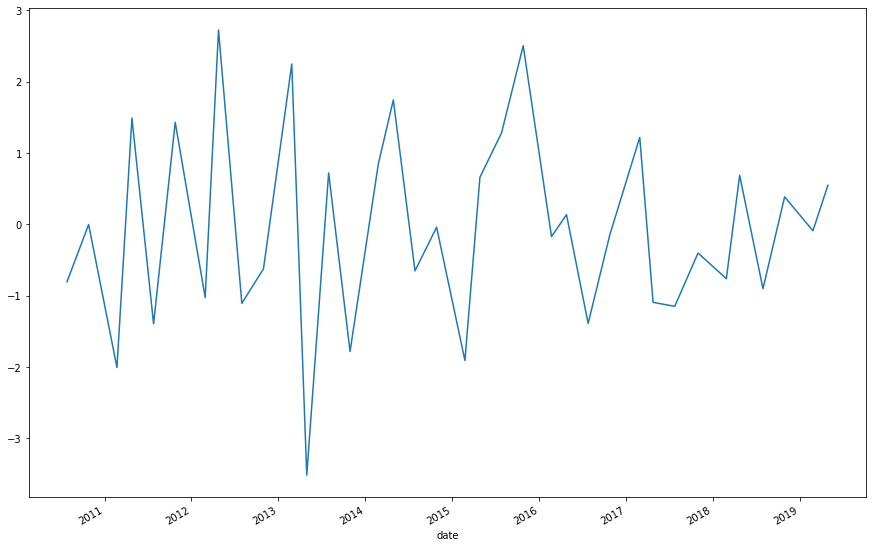

In [74]:
y_roll.plot(figsize=(15,10))
plt.show()

In [75]:
# I'm going to try with no differencing and with one seasonal diff and see which is better.
import pmdarima as pm
#model1 = pm.auto_arima(df1, seasonal=True, m=7, d=0, D=1, max_p=2, max_q=2,
#                       trace=True, error_action='ignore', suppress_warnings=True)

ModuleNotFoundError: No module named 'pmdarima'